# Lab 5 - Settlers of Catan Trailer

#### Authors:

v1.0 (2016 Spring) David Marn, Ashvin Nair, Kabir Chandrasekher, Tony Duan, Kangwook Lee, Kannan Ramchandran  

This trailer introduces you to a modified version of the board game "Settlers of Catan". If you choose to do the Catan project, you will come up with a probabilistic model of Catan and optimize a strategy to dominate opponents! _Just run through this trailer to get a preview of the project -- there is no code to write._

## Introduction
The goal of the game is to get $10$ victory points as fast as possible. To get these points, the player must choose a wise trade-off between spending resources to potentially obtain points and upgrading their modes of production. You, the chieftain of the island, must decide where and when to build additional <font color=purple>settlements</font> on the island to boost your resource production. Alternatively, you can invest into development cards, which will bring you a victory point, or upgrade a settlement into a <font color=blue>city</font> which doubles production and gives you another victory point. A village must border on a resource field in order to harvest its resources. We will have three different terrains: forests, which produce <font color=brown>wood</font>, hills which produce <font color=red>brick</font>, fields of <font color=gray>grain</font> (grain), sheep (white) and ore (blue). Every turn, we roll two dice and record the sum $X$. The settlements that are next to the tile that is labelled with $X$ get one resource from that field, and we keep collecting resources and building up to 10 victory points.

## Game layout

Our modified Catan board is drawn below.

Tiles are color coded with the resource they produce: <font color=brown>wood</font>, <font color=red>brick</font>, <font color=green>grain</font>, <font color=grey>sheep</font>, <font color=blue>ore</font>.

You build <font color=purple>settlements</font> and <font color=blue>cities</font> on vertices of the board. The small green square is a settlement, labeled "1" because it gives you one resource of the surrounding tiles when the corresponding number is rolled. The small blue square is a city and gives you 2 resources from surrounding tiles.

In [1]:
import numpy as np
from catan import Catan, CatanException, get_random_dice_arrangement, Player, simulate_game, simulate_game_and_save
import matplotlib.pyplot as plt
from itertools import repeat
%matplotlib inline
width, height = 3, 3
dice = get_random_dice_arrangement(width, height)
count = np.array([])
while 0 in count or count.shape[0] != 5:
    resources = np.random.randint(0, 5, (height, width))
    count = np.bincount(np.reshape(resources, (1, resources.shape[0] * resources.shape[1]))[0])
board = Catan(dice, resources, [5, 6], [10], [(5, 6), (6, 10)])

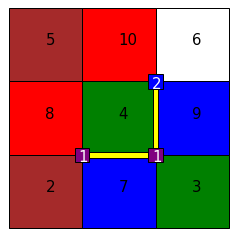

In [2]:
board.draw()


## Rules
When implementing the game, remember to follow these rules:
<ul>
<li> Every turn you roll 2 dice, call the sum X </li>
<li> Find the tiles labeled with the number X and collect one of that resource for every settlement and two of that resource for every city on a vertex of that tile </li>
<li> You can never have more than 4 of any resource: if you get extra, you just keep 4 </li>
<li> You can build by paying resources according to the costs below, and building anything gives you 1 victory point </li>
<li> You can only build roads that start from a settlement or city </li>
<li> You can only build a settlement if it located on a road (except for the first settlement) </li>
</ul>

## Costs
You can build villages, which boost your production (but bring no victory points), or buy development cards which can bring you an additional victory point.

The costs are given below, and stored in the array costs for convenience.

In [15]:
import numpy as np
import pandas as pd

costs = np.array([[2, 3, 1, 1, 1],
                  [2, 2, 2, 0, 1],
                  [4, 2, 2, 2, 2],
                  [1, 3, 1, 0, 0]])

resources = ['wood', 'brick', 'grain', 'sheep', 'ore']
buildings = ['settlement', 'card', 'city', 'road']
df = pd.DataFrame(costs, index=buildings, columns=resources)
html = df.to_html()
from IPython.core.display import HTML
HTML(html)

,wood,brick,grain,sheep,ore
settlement,2,3,1,1,1
card,2,2,2,0,1
city,4,2,2,2,2
road,1,3,1,0,0


##  <font color=blue>$\mathcal{Q}$1. Learning the Game</font>

The Catan board is implemented for you, with utilities to draw and get a table of resources gained. In particular you will find these two functions useful:

`board = Catan(dice, resources, settlements, cities)`

The constructor initializes our Catan board. Dice and resources must be the same shape: HxW where H is the height of the board and W is the width. dice[i,j] is the dice number that tile corresponds to (each element between 2-12 inclusive) and resources[i,j] is the resource that tile  provides. Settlements is a list of vertices with settlements on them, and likewise for cities.

`board.get_resources()`

This returns a 11x5 numpy array of resources gained for each possible dice sum. That is, r[i, :] = resources gained from throwing a (i+2).

[[ 1.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.]
 [ 0.  0.  4.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  2.  0.]
 [ 0.  0.  0.  0.  2.]
 [ 0.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  3.]
 [ 0.  2.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]]
3 3


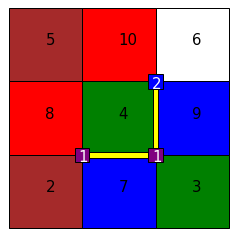

In [4]:
board.draw()
print board.get_resources()
print board.height, board.width
# wood is brown, brick is red, grain is green
# below is the resource outcome of a dice roll

## Game Simulation

Run the code below to see a game in action! This will use our (bad) sample policy.

In [6]:
# sample action function
def action(self, resources, costs):
    # inputs:
    # resources - an array of resources
    # costs - an array of costs, 0 - settlement, 1 - card, 2 - city, 3 - road
    # basic strategy: Once we get 4 of one resource and less than 2 of any other, we make a trade. 
    # Then we try to buy development cards
    
    if self.board.settlements == []:
        x = np.random.randint(0, self.board.width + 1)
        y = np.random.randint(0, self.board.height + 1)
        self.board.build(x, y, "settlement")
    if self.if_can_buy("card"):
        self.buy("card")
        return
    if self.if_can_buy("settlement"):
        for x in range(self.board.width+1):
            for y in range(self.board.height+1):
                if self.board.if_can_build("settlement", x, y):
                    self.buy("settlement", x, y)
                    return
    if self.if_can_buy("road"):
        for x in range((self.board.width+1)*(self.board.height+1) - 1):
            for y in (x+1, x+self.board.width+1):
                if (y > (self.board.width+1)*(self.board.height+1) - 1):
                    continue
                if self.board.if_can_build("road", x, y):
                    self.buy("road", x, y)
                    return
    
    if self.resources[np.argmax(self.resources)] >= 4 and self.resources[np.argmin(self.resources)] < 2:
        rmax, rmin = np.argmax(self.resources), np.argmin(self.resources)
        self.resources[rmax] -= 4
        self.resources[rmin] += 1
    return

num_trials = 100
print simulate_game(action, board, num_trials)

1252.39


In [13]:
roads, settlements, cities, hands, live_points, dice_rolls = simulate_game_and_save(action, board)

def draw(t):
    t = int(t)
    live_board = Catan(board.dice, board.resources, [], [], [])
    live_board.settlements = settlements[t]
    live_board.cities = cities[t]
    live_board.roads = roads[t]
    print "turn:", t
    print "points:", live_points[t]
    print "dice roll:", dice_rolls[t]
    print "settlements:", settlements[t]
    print "roads:", roads[t]
    print "resources:", hands[t]
    live_board.draw()

turn: 616
points: 10
dice roll: 8
settlements: [8, 4, 0, 12, 1, 5]
roads: [(4, 8), (8, 9), (8, 12), (0, 4), (4, 5), (0, 1), (1, 2)]
resources: [ 1.  1.  0.  0.  2.]


None

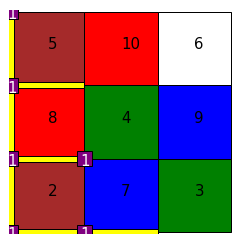

In [14]:
from IPython.html.widgets import *
interact(draw, t=(0, len(live_points) - 1, 1))

In the Catan project you will work on building a Markov chain for the game to analyze it formally, and calculate the expected time to build buildings. Then, you will come up with a policy to play the game and work on some creative extension of your choice.

If you're choosing Catan, open up the Catan lab notebook, where we've written some skeleton code to direct you Enjoy!